This model is currently a work in progress and not working properly as of yet

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

We are using the FashionMNIST Dataset to train our model initially to reduce complexity.

https://www.kaggle.com/datasets/zalando-research/fashionmnist



We will do a second round of training and hyperparameter tuning with the DeepFashion2 dataset.

https://github.com/switchablenorms/DeepFashion2


In [2]:
# Load the Fashion MNIST dataset
(X_train, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
# Normalize the images to [-1, 1]
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
# Reshape to add a channel dimension
X_train = np.expand_dims(X_train, axis=-1)


4422102/4422102 [==============================] - 1s 0us/step


In [3]:
# Generator model
def build_generator():
    model = Sequential()
    model.add(Dense(7 * 7 * 256, activation="relu", input_dim=100))
    model.add(Reshape((7, 7, 256)))
    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(1, kernel_size=7, padding="same", activation='tanh'))
    return model

# Discriminator model
def build_discriminator():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=4, strides=2, input_shape=(28, 28, 1), padding="same"))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.3))
    model.add(Conv2D(128, kernel_size=4, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

# GAN model
def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

In [4]:
# Build and compile discriminator
discriminator = build_discriminator()
discriminator.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Build generator
generator = build_generator()

# Build and compile GAN
discriminator.trainable = False
gan = build_gan(generator, discriminator)
gan.compile(optimizer=Adam(), loss='binary_crossentropy')


2/2 [==============================] - 1s 178ms/step
0 [D loss: 0.6851596534252167, acc.: 42.1875] [G loss: 0.681892991065979]
1/1 [==============================] - 0s 143ms/step


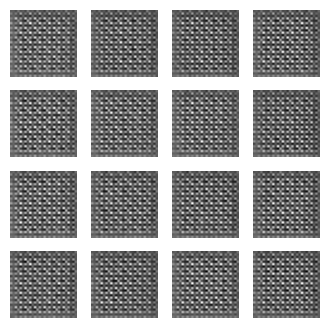

2/2 [==============================] - 0s 128ms/step
10 [D loss: 1.1381670739501715, acc.: 50.0] [G loss: 0.4820556640625]
1/1 [==============================] - 0s 68ms/step


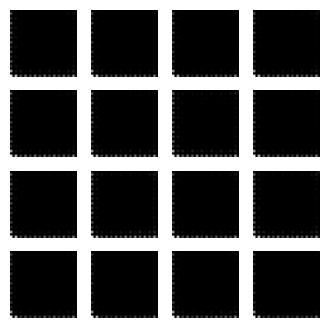

2/2 [==============================] - 0s 106ms/step
20 [D loss: 0.19499597698450089, acc.: 96.09375] [G loss: 1.7668143510818481]
1/1 [==============================] - 0s 68ms/step


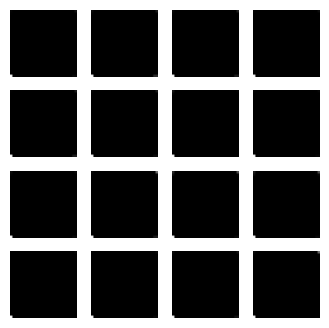

2/2 [==============================] - 0s 171ms/step
30 [D loss: 0.04198528081178665, acc.: 99.21875] [G loss: 3.463372230529785]
1/1 [==============================] - 0s 72ms/step


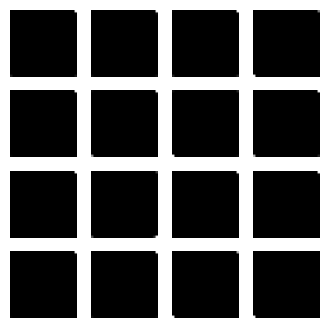

2/2 [==============================] - 0s 105ms/step
40 [D loss: 0.011641683522611856, acc.: 100.0] [G loss: 4.927422523498535]
1/1 [==============================] - 0s 69ms/step


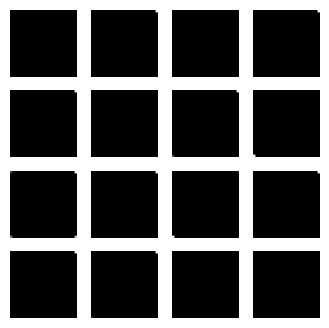

2/2 [==============================] - 0s 106ms/step
50 [D loss: 0.016575215384364128, acc.: 99.21875] [G loss: 4.909804821014404]
1/1 [==============================] - 0s 68ms/step


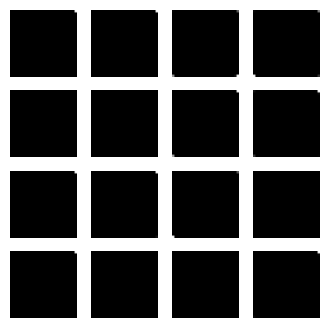

2/2 [==============================] - 0s 168ms/step
60 [D loss: 0.0030217993771657348, acc.: 100.0] [G loss: 5.7836103439331055]
1/1 [==============================] - 0s 68ms/step


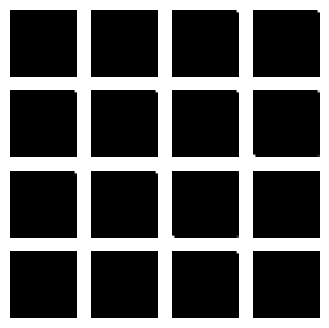

2/2 [==============================] - 0s 107ms/step
70 [D loss: 0.00156375156075228, acc.: 100.0] [G loss: 6.132170677185059]
1/1 [==============================] - 0s 93ms/step


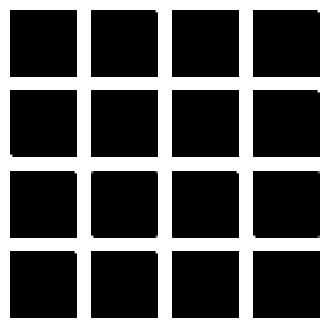

2/2 [==============================] - 0s 119ms/step
80 [D loss: 0.0010478823805897264, acc.: 100.0] [G loss: 6.6378889083862305]
1/1 [==============================] - 0s 68ms/step


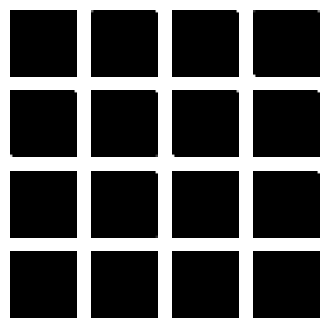

2/2 [==============================] - 0s 105ms/step


KeyboardInterrupt: 

In [5]:
def train_gan(gan, generator, discriminator, epochs=20, batch_size=128, sample_interval=200):
    X_train, _ = tf.keras.datasets.fashion_mnist.load_data()
    X_train = (X_train[0].astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=-1)
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        # Train discriminator
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_imgs = X_train[idx]
        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        g_loss = gan.train_on_batch(noise, real)

        if epoch % sample_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}] [G loss: {g_loss}]")
            sample_images(generator, epoch)

def sample_images(generator, epoch, image_grid_rows=4, image_grid_columns=4):
    noise = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, 100))
    gen_imgs = generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5  # Rescale images 0 - 1
    fig, axs = plt.subplots(image_grid_rows, image_grid_columns, figsize=(4, 4), sharey=True, sharex=True)
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

train_gan(gan, generator, discriminator, epochs=100, batch_size=64, sample_interval=10)
